In [197]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The Einstein process

In [358]:
tmax = 100.0
dt = 1e-2
k1 = 2.0 # rest
k2 = 1.0 #step
t = np.arange(0,tmax,dt)
def einwalk(k1=2.0,k2=1.0,dt=1e-2,tmax=10):
    X = []
    T = []
    t = 0.0
    x = 0.0
    tau = np.random.exponential(1/k1)
    while t<tmax:
        T.append(t)
        t = t + dt
        if t<tau:
            X.append(x)
        else:
            tau += np.random.exponential(1/k1)
            x = x + np.random.exponential(1/k2)
            X.append(x)        
    return T[:-1],X[:-1]

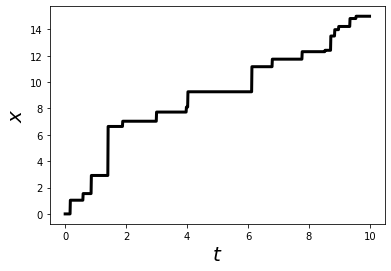

In [359]:
plt.plot(*einwalk(),color='black',lw=3)
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20)
plt.savefig('einsteinwalk.png',bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (100000,) and (99999,)

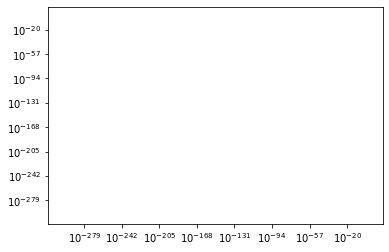

In [363]:
ens = np.array([einwalk(k1=1,k2=1,dt=1e-3,tmax=100)[1] for _ in range(1000)])
t = np.arange(0,100,1e-3)


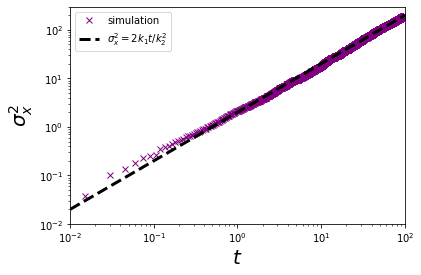

In [377]:
plt.loglog(t[:-1][::15],ens.var(0)[::15],'x',color='purple',zorder=-1,label='simulation')
plt.xlim(1e-2,1e2)
plt.ylim(1e-2)
tt = np.geomspace(1e-2,1e2,100)
plt.loglog(tt,2*tt,color='black',lw=3,zorder=1,linestyle='--',label=r'$\sigma_x^2 = 2k_1 t/k_2^2$')
plt.legend()
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$\sigma_x^2$',fontsize=20)
plt.savefig('einsteinvar.png',bbox_inches='tight')

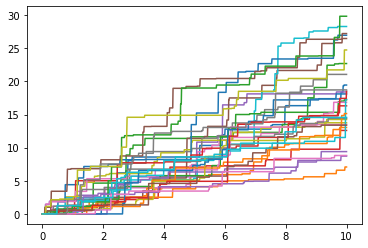

In [353]:
for _ in range(30):
    plt.plot(*einwalk())

# The Lisle process

In [198]:
# first code up the lisle process from any initial conditions
def walkit(k0=1.0,k1=1.0,v=1.0,tmax=10,theta0=0.5,theta1=0.5):
    """
    k0 is the inverse mean resting time
    k1 is the inverse mean moving time
    v is the velocity
    tmax is the maximum time to walk
    theta0 is the probability of starting at rest
    theta1 is the probability of starting in motion
    """
    S = []
    T = []
    s = int(np.random.random() > theta0) # initial state
    t = 0.0 # initial time
    T.append(t)
    S.append(s)
    while t<tmax:
        if s==0:
            t = t + np.random.exponential(1/k0)
            S.append(s)            
            s = 1 
            T.append(t)
        elif s==1:
            t = t + np.random.exponential(1/k1)
            S.append(s)            
            s = 0
            T.append(t)
    return np.array(T),np.array(S)

def plotit(walk):
    t,s = walk
    widths = np.diff(t)
    plt.bar(t[:-1],s[:-1]+1,width=widths,edgecolor='black',facecolor='purple',align='edge',zorder=-1)
    
def dispit(walk,ts,v=1.0):
    t,xs = walk
    i = np.searchsorted(t,ts,side='left')
    xs = xs[i]
    dt = ts[1]-ts[0]
    xs = (xs*v*dt).cumsum()
    return xs

(0, 30)

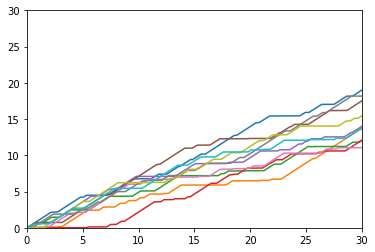

In [199]:
for i in range(10):
    walk = walkit(k0=1,k1=1,tmax=30)
    tm = walk[0].max()
    ts = np.arange(0,30,1e-3)
    xs = dispit(walk,ts)
    plt.plot(ts,xs)
plt.xlim(0,30)
plt.ylim(0,30)

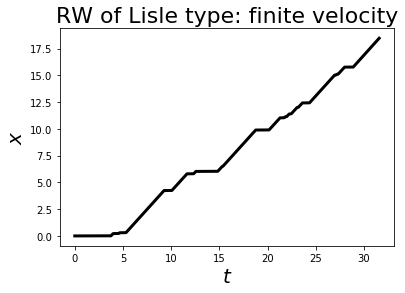

In [200]:
walk = walkit(k0=0.9,k1=1,tmax=30)
tm = walk[0].max()
ts = np.arange(0,tm,1e-3)
xs = dispit(walk,ts)
plt.plot(ts,xs,lw=3,color='black')
plt.title('RW of Lisle type: finite velocity',fontsize=22)
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$x$',fontsize=20)
plt.savefig('lisle_rw.png',bbox_inches='tight')

In [201]:
def ensit(n=10,k0=1.0,k1=1.0,dt=1e-1,v=1.0,tmax=10,theta0=0.5,theta1=0.5):
    T = np.arange(0,tmax,dt)
    X = []
    for i in range(n):
        walk = walkit(k0=k0,k1=k1,v=v,tmax=tmax,theta0=theta0,theta1=theta1)
        x = dispit(walk,T,v=v)
        X.append(x)
    X = np.array(X)
    return T,X

def statsit(ensemble):
    T,X = ensemble
    var = X.var(0)
    mean = X.mean(0)
    return T,mean,var

/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


Text(0.5, 1, 'Lisle variance scaling')

/home/kpierce/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:122: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


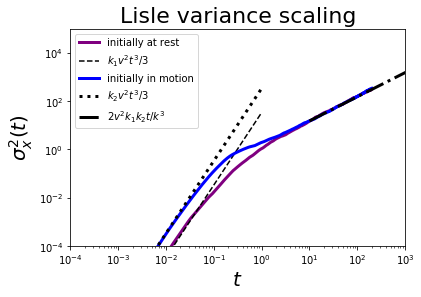

In [208]:
# compare the two different initial conditions
n = 500 # number of samples
tmax = 200.0 # max simulation time
dt = 1e-4 # timestep for analysis
k0 = 1  #inverse mean rest time
k1 = 10 #inverse mean motion time
v = 10

# first do rest
trest,meanrest,varrest = statsit(ensit(n=n,tmax=tmax,dt=dt,theta0=1,theta1=0,k0=k0,k1=k1,v=v))
plt.loglog(trest,varrest,label='initially at rest',color='purple',lw=3)
# plot its small t asymptotic result
t0 = np.geomspace(1e-3,1,100)
var0 = 1/3*v**2*k0*t0**3
plt.loglog(t0, var0,linestyle='--',color='black',label=r'$k_1 v^2 t^3/3$')

# then do motion
tmotion,meanmotion,varmotion = statsit(ensit(n=n,tmax=tmax,dt=dt,theta0=0,theta1=1,k0=k0,k1=k1,v=v))
plt.loglog(tmotion,varmotion,label='initially in motion',color='blue',lw=3)
# plot its small t asymptotic result
t0 = np.geomspace(1e-3,1,100)
var0 = 1/3*v**2*k1*t0**3
plt.loglog(t0, var0,linestyle=':',color='black',label=r'$k_2 v^2 t^3/3$',lw=3)

# plot the large t asymptotic result
t0 = np.geomspace(1e1,1e5,100)
var0 = 2*k0*k1*t1*v**2/(k0+k1)**3
plt.loglog(t0,var0,linestyle='-.',label=r'$2v^2k_1k_2 t/k^3$',color='black',lw=3)

# now control the plot settings
plt.legend()
plt.xlim(1e-4,1e3)
plt.ylim(1e-4,1e5)
plt.ylabel(r'$\sigma_x^2(t)$',fontsize=20)
plt.xlabel(r'$t$',fontsize=20)
plt.savefig("Lisle1998-behavior.png",bbox_inches='tight')
plt.title('Lisle variance scaling',fontsize=22)

In [169]:
def var_rest(t,k0,k1,v):
    e = np.exp(1)
    k = k0 + k1
    out = -k*t - (2*k*t+2)*e**(-k*t) + 5/2 - 1/2*e**(-2*k*t)
    out += k/k0*(k*t-2+(k*t+2)*e**(-k*t))
    out *= k0**2*v**2*2/k**4
    return out

def var_motion(t,k0,k1,v):
    e = np.exp(1)
    k = k0 + k1
    out = k0*k1*(k*t -2 + (2+k*t)*e**(-k*t))
    out += k1**2*(1/2-k*t*e**(-k*t)-1/2*e**(-2*k*t))
    out *= 2*v**2/k**4
    return out

/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/kpierce/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:122: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


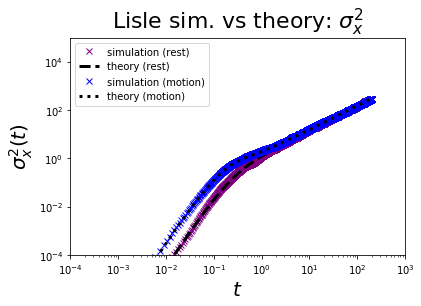

In [203]:
plt.loglog(trest[::15],varrest[::15],'x',label='simulation (rest)',color='purple')
plt.loglog(trest[::15],var_rest(trest[::15],k0,k1,v),color='black',lw=3,linestyle='--',label='theory (rest)')
plt.loglog(tmotion[::15],varmotion[::15],'x',label='simulation (motion)',color='blue')
plt.loglog(tmotion[::15],var_motion(tmotion[::15],k0,k1,v),color='black',lw=3, linestyle=':',label='theory (motion)')

plt.xlim(1e-4,1e3)
plt.ylim(1e-4,1e5)
plt.ylabel(r'$\sigma_x^2(t)$',fontsize=20)
plt.xlabel(r'$t$',fontsize=20)
plt.title(r'Lisle sim. vs theory: $\sigma_x^2$',fontsize=22)
plt.legend()
plt.savefig('sim-vs-theory-lisle.png',bbox_inches='tight')

In [204]:
def mean_motion(t,k0,k1,v):
    e = np.exp(1)
    k = k0 + k1
    out = k0*k*t + k1*(1-e**(-k*t))
    out *= v/k**2
    return out 

def mean_rest(t,k0,k1,v):
    e = np.exp(1)
    k = k0 + k1
    out = e**(-k*t) + k*t -1
    out *= v*k0/k**2
    return out 

/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/kpierce/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:122: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


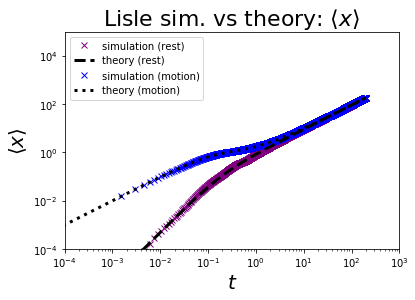

In [205]:
plt.loglog(trest[::15],meanrest[::15],'x',label='simulation (rest)',color='purple',zorder=-1)
plt.loglog(trest[::15],mean_rest(trest[::15],k0,k1,v),color='black',lw=3,linestyle='--',label='theory (rest)',zorder=1)
plt.loglog(tmotion[::15],meanmotion[::15],'x',label='simulation (motion)',color='blue',zorder=-1)
plt.loglog(tmotion[::15],mean_motion(tmotion[::15],k0,k1,v),color='black',lw=3, linestyle=':',label='theory (motion)')

plt.xlim(1e-4,1e3)
plt.ylim(1e-4,1e5)
plt.ylabel(r'$\langle x \rangle$',fontsize=20)
plt.xlabel(r'$t$',fontsize=20)
plt.title(r'Lisle sim. vs theory: $\langle x \rangle$',fontsize=22)
plt.legend()
plt.savefig('sim-vs-theory-lisle-mean.png',bbox_inches='tight')

In [206]:
# now do arbitrary initial conditions 
# compare the two different initial conditions
n = 500 # number of samples
tmax = 200.0 # max simulation time
dt = 1e-4 # timestep for analysis
k0 = 1  #inverse mean rest time
k1 = 10 #inverse mean motion time
v = 10
VARS = []
for theta0,theta1 in [[0,1],[0.25,0.75],[0.5,0.5],[0.75,0.25],[1,0]]:
    ts, _, var = statsit(ensit(n=n,tmax=tmax,dt=dt,theta0=theta0,theta1=theta1,k0=k0,k1=k1,v=v))
    VARS.append(var[::15])
    print('one down..')

one down..
one down..
one down..
one down..
one down..


/home/kpierce/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/kpierce/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:122: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


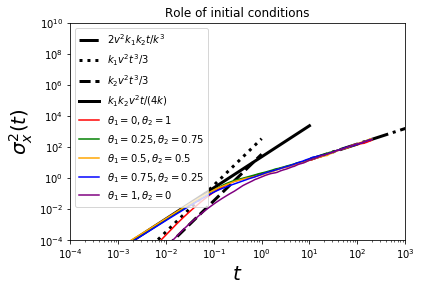

In [207]:
conds = [0,1],[0.25,0.75],[0.5,0.5],[0.75,0.25],[1,0]
colors = ['red','green','orange','blue','purple']
i=0

# plot large t asymptotic result 
t0 = np.geomspace(1e1,1e5,100)
var0 = 2*k0*k1*t0*v**2/(k0+k1)**3
plt.loglog(t0,var0,linestyle='-.',label=r'$2v^2k_1k_2 t/k^3$',color='black',lw=3)

# plot its small t asymptotic result
t0 = np.geomspace(1e-3,1,100)
var0 = 1/3*v**2*k1*t0**3
plt.loglog(t0, var0,linestyle=':',color='black',label=r'$k_1 v^2 t^3/3$',lw=3)
var0 = 1/3*v**2*k0*t0**3
plt.loglog(t0, var0,linestyle='--',color='black',label=r'$k_2 v^2 t^3/3$',lw=3)
t0 = np.geomspace(1e-3,10,100)
var0 = 1/4*v**2*k0*k1*t0**2/(k0+k1)
plt.loglog(t0,var0,color='black',lw=3,label=r'$k_1k_2 v^2 t/(4k)$')


for c,vary in zip(colors,VARS):
    a,b = conds[i]
    label = r'$\theta_1= {}, \theta_2={}$'.format(round(a,2),round(b,2))
    plt.loglog(ts[::15],vary,color=c,label=label)
    i+=1
plt.xlim(1e-4,1e3)
plt.ylim(1e-4,1e10)
plt.ylabel(r'$\sigma_x^2(t)$',fontsize=20)
plt.xlabel(r'$t$',fontsize=20)
plt.title('Role of initial conditions')
plt.legend()
plt.savefig('lisle-initial-conditions.png',bbox_inches='tight')